In [1]:
import re
import os
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.corpus import wordnet 
allEnglishWords = words.words() + [w for w in wordnet.words()]
allEnglishWords = np.unique([x.lower() for x in allEnglishWords])
from IPython.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import PCA
import scikitplot.plotters as skplt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

## Loading the Data Set

In [2]:
path = "aclImdb/"

In [3]:
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]

In [4]:
pos_Reviews, neg_Reviews= [], []

In [5]:
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        pos_Reviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        neg_Reviews.append(f.read())


## Merging the Pos and Neg tweets:

In [6]:
reviews = pd.concat([
    pd.DataFrame({"review":pos_Reviews[:3500], "label":1}),
    pd.DataFrame({"review":neg_Reviews[:3500], "label":0}),
    ], ignore_index=True).sample(frac=1, random_state=1)


In [7]:
reviews = reviews[["review", "label"]].sample(frac=1, random_state=1)


In [8]:
reviews.head(10)

,review,label
2718,There's a great deal of material from the Mode...,1
170,I caught this film at a test screening. Was ve...,1
3972,"This movie is great, mind you - but only in th...",0
5453,For those looking for a sequel for the fine So...,0
1955,Why did this movie fail commercially? It's got...,1
946,"Hello, I was alanrickmaniac. I'm a Still Crazy...",1
4141,"Horror fans (I'm speaking to the over 12's, al...",0
4440,"The directors cut version, which was the one I...",0
3627,This is one of the worst films ever. I like ch...,0
1348,This second film is just as interesting as the...,1


## Seperating the Train and validation data set

In [9]:
train = reviews[reviews.label!=-1].sample(frac=0.7143, random_state=1)
valid = reviews[reviews.label!=-1].drop(train.index)

In [10]:
print(train.shape)
print(valid.shape)


(5000, 2)
(2000, 2)


In [11]:
train.head(10)

,review,label
5480,What a crappy movie! The worst of the worst! T...,0
5305,"Except for the Brady Variety Hour, this was so...",0
2315,A toothsome little potboiler whose 65-minute l...,1
6825,"Contrary to its title, this film offers no spi...",0
995,What would you expect from a film titled 'Surv...,1
4087,1st watched 12/6/2009 - 4 out of 10 (Dir-Walte...,0
6534,Did they use their entire budget paying the po...,0
6055,I would put this at the top of my list of film...,0
5391,"No, I haven't read the Stephen King novel ""Thi...",0
1586,In reflecting on this movie I can think of two...,1


In [12]:
valid.head(10)

,review,label
2718,There's a great deal of material from the Mode...,1
3972,"This movie is great, mind you - but only in th...",0
3627,This is one of the worst films ever. I like ch...,0
3720,"People, please don't bother to watch this movi...",0
6399,here was no effort put into Valentine to preve...,0
4338,I can't really think of any redeeming features...,0
2080,"In 1983, Director Brian De Palma set out to ma...",1
5630,"This seemed to be a good movie, I thought it w...",0
4240,Don't get fooled with all the big names like B...,0
254,YETI deserves the 8 star rating because it is ...,1


## PreProcessing of Text Data set:

In [14]:
class Preprocessor:
    
    def __init__(self, alpha=True, lower=True, stemmer=True, english=False):
        self.alpha = alpha
        self.lower = lower
        self.stemmer = stemmer
        self.english = english
        
        self.uniqueWords = None
        self.uniqueStems = None
        
    def fit(self, texts):
        texts = self._clean(texts)

        allwords = pd.DataFrame({"word": np.concatenate(texts.apply(lambda x: x.split()).values)})
        self.uniqueWords = allwords.groupby(["word"]).size().rename("count").reset_index()
        self.uniqueWords = self.uniqueWords[self.uniqueWords["count"]>1]
        if self.stemmer:
            self.uniqueWords["stem"] = self.uniqueWords.word.apply(lambda x: PorterStemmer().stem(x)).values
            self.uniqueWords.sort_values(["stem", "count"], inplace=True, ascending=False)
            self.uniqueStems = self.uniqueWords.groupby("stem").first()
        
        #if self.english: self.words["english"] = np.in1d(self.words["mode"], allEnglishWords)
        print("Fitted.")
            
    def transform(self, texts):
        texts = self._clean(texts)
        if self.stemmer:
            allwords = np.concatenate(texts.apply(lambda x: x.split()).values)
            uniqueWords = pd.DataFrame(index=np.unique(allwords))
            uniqueWords["stem"] = pd.Series(uniqueWords.index).apply(lambda x: PorterStemmer().stem(x)).values
            uniqueWords["mode"] = uniqueWords.stem.apply(lambda x: self.uniqueStems.loc[x, "word"] if x in self.uniqueStems.index else "")
            texts = texts.apply(lambda x: " ".join([uniqueWords.loc[y, "mode"] for y in x.split()]))
        #if self.english: texts = self.words.apply(lambda x: " ".join([y for y in x.split() if self.words.loc[y,"english"]]))
        print("Transformed.")
        return(texts)

    def fit_transform(self, texts):
        texts = self._clean(texts)
        self.fit(texts)
        texts = self.transform(texts)
        return(texts)
    
    def _clean(self, texts):
        # Remove parts between <>'s
        texts = texts.apply(lambda x: re.sub('<.*?>', ' ', x))
        # Keep letters and digits only.
        if self.alpha: texts = texts.apply(lambda x: re.sub('[^a-zA-Z0-9 ]+', ' ', x))
        # Set everything to lower case
        if self.lower: texts = texts.apply(lambda x: x.lower())
        return texts 

In [15]:
preprocess = Preprocessor(alpha=True, lower=True, stemmer=True)

## Preprocessing and converting into pandas series:

In [16]:
%%time
trainX = preprocess.fit_transform(train.review)


Fitted.
Transformed.
Wall time: 14.2 s


In [17]:
validX = preprocess.transform(valid.review)

Transformed.


In [18]:
type(trainX)

pandas.core.series.Series

In [19]:
trainX.head()

5480    what a crappy movie the worst of the worst thi...
5305    except for the brady variety hour this was som...
2315    a toothsome little potboiler whose 65 minutes ...
6825    contrary to it title this film offer no spice ...
995     what would you expect from a film title surviv...
Name: review, dtype: object

## Loading NLTK stop words and adding some extra stop words

In [20]:
stop_words = text.ENGLISH_STOP_WORDS.union(["thats","weve","dont","lets","youre","im","thi","ha",
    "wa","st","ask","want","like","thank","know","susan","ryan","say","got","ought","ive","theyre",])

In [21]:
validX.head()

2718    there s a great deal of material from the mode...
3972    this movie is great mind you but only in the w...
3627    this is one of the worst film ever i like chee...
3720    people please don t bother to watch this movie...
6399    here was no effort put into valentine to preve...
Name: review, dtype: object

## Using frequency based wordembedding technique : TfidfVectorizer

In [22]:
tfidf = TfidfVectorizer(min_df=2, max_features=10000, stop_words=stop_words) 

In [23]:
trainX = tfidf.fit_transform(trainX).toarray()

In [24]:
validX = tfidf.transform(validX).toarray()

In [25]:
type(trainX)

numpy.ndarray

In [26]:
print(trainX.shape)
print(validX.shape)

(5000, 10000)
(2000, 10000)


In [27]:
trainY = train.label
validY = valid.label

## Correlation with Output variable:

In [28]:
from scipy.stats.stats import pearsonr

In [29]:
getCorrelation = np.vectorize(lambda x: pearsonr(trainX[:,x], trainY)[0])
correlations = getCorrelation(np.arange(trainX.shape[1]))
print(correlations)

[-0.00631142 -0.01309727  0.02569545 ... -0.02009554  0.00346197
 -0.02424504]


In [30]:
allIndeces = np.argsort(-correlations)
bestIndeces = allIndeces[np.concatenate([np.arange(1000), np.arange(-1000, 0)])]

In [31]:
 allIndeces

array([3945, 3156,  890, ..., 9691, 9875,  772], dtype=int64)

In [32]:
bestIndeces[1200]

3085

In [33]:
trainX = trainX[:,bestIndeces]
validX = validX[:,bestIndeces]

In [34]:
print(trainX.shape, trainY.shape)
print(validX.shape, validY.shape)

(5000, 2000) (5000,)
(2000, 2000) (2000,)


In [35]:

trainX.shape[1]

2000

## Loading Keras Sequential Model 

In [38]:
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras import optimizers

DROPOUT = 0.5
ACTIVATION = "tanh"


In [39]:
import random
random.seed(1)

## Adding the Layers into the model:

In [41]:
model = Sequential([    
    
    Dense(int(1000), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(1000), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(500), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(100, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(20, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(5, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid'),
])

### Compilation of model

In [42]:
model.compile(optimizer=optimizers.Adam(0.00005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               50100     
__________

In [52]:
epochs = 50
batchsize = 1500

### Training the Model using training data set

In [53]:
model.fit(trainX, trainY, epochs=epochs, batch_size=batchsize, validation_data=(validX, validY))

Train on 5000 samples, validate on 2000 samples
Epoch 1/50
5000/5000 [==============================] - 2s 433us/sample - loss: 0.1854 - acc: 0.9670 - val_loss: 0.3524 - val_acc: 0.8660
Epoch 2/50
5000/5000 [==============================] - 2s 385us/sample - loss: 0.1784 - acc: 0.9680 - val_loss: 0.3532 - val_acc: 0.8650
Epoch 3/50
5000/5000 [==============================] - 2s 397us/sample - loss: 0.1838 - acc: 0.9650 - val_loss: 0.3541 - val_acc: 0.8635
Epoch 4/50
5000/5000 [==============================] - 2s 408us/sample - loss: 0.1820 - acc: 0.9650 - val_loss: 0.3550 - val_acc: 0.8630
Epoch 5/50
5000/5000 [==============================] - 2s 424us/sample - loss: 0.1805 - acc: 0.9652 - val_loss: 0.3556 - val_acc: 0.8650
Epoch 6/50
5000/5000 [==============================] - 2s 424us/sample - loss: 0.1707 - acc: 0.9696 - val_loss: 0.3563 - val_acc: 0.8650
Epoch 7/50
5000/5000 [==============================] - 2s 449us/sample - loss: 0.1764 - acc: 0.9698 - val_loss: 0.3575 - va

### Evaluation with validation data set:

In [51]:
scores = model.evaluate(validX, validY, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

Accuracy= 86.55%


## Ploting the Confusion Matrix:

In [54]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

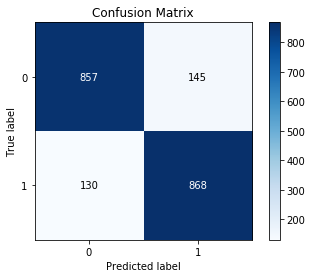

In [55]:
y_pred = model.predict_classes(validX)
plot_cmat(validY, y_pred)